In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.stats import chisquare
import scipy.stats as ss

from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.columns)

print(df.dtypes)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


Number of missing values or spaces

In [3]:
for column in df.columns:
    
    print(column)
    
    print(df[df[column] == ' '].index)

customerID
Int64Index([], dtype='int64')
gender
Int64Index([], dtype='int64')
SeniorCitizen
Int64Index([], dtype='int64')
Partner
Int64Index([], dtype='int64')
Dependents
Int64Index([], dtype='int64')
tenure
Int64Index([], dtype='int64')
PhoneService
Int64Index([], dtype='int64')
MultipleLines
Int64Index([], dtype='int64')
InternetService
Int64Index([], dtype='int64')
OnlineSecurity
Int64Index([], dtype='int64')
OnlineBackup
Int64Index([], dtype='int64')
DeviceProtection
Int64Index([], dtype='int64')
TechSupport
Int64Index([], dtype='int64')
StreamingTV
Int64Index([], dtype='int64')
StreamingMovies
Int64Index([], dtype='int64')
Contract
Int64Index([], dtype='int64')
PaperlessBilling
Int64Index([], dtype='int64')
PaymentMethod
Int64Index([], dtype='int64')
MonthlyCharges
Int64Index([], dtype='int64')
TotalCharges
Int64Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')
Churn
Int64Index([], dtype='int64')


Remove rows with spaces

In [4]:
print("Tenure of customers with zero total charges: ",df[df["TotalCharges"]==" "]["tenure"])
# These customers seem to have registered but not started with their service to be evaluated. Hence, they will be excluded
df = df[df["TotalCharges"]!=" "] 

Tenure of customers with zero total charges:  488     0
753     0
936     0
1082    0
1340    0
3331    0
3826    0
4380    0
5218    0
6670    0
6754    0
Name: tenure, dtype: int64


- EDA for most recognisable fields
  - Gender 
  - Senior citizen
  - Partner
  - Dependents
  - Tenure
  - Phone service
  - Multiple Lines
  - Internet service
  - Online security
  - Online backup
  - Device protection
  - Tech Suppport
  - Streaming TV
  - Streaming movies
  - Contract
  - Paper less Billing
  - Payment method
  

In [5]:
for column in df.columns:
    
    print("For "+ column+ ":" + str(df[column].nunique()) + "unique values")

For customerID:7032unique values
For gender:2unique values
For SeniorCitizen:2unique values
For Partner:2unique values
For Dependents:2unique values
For tenure:72unique values
For PhoneService:2unique values
For MultipleLines:3unique values
For InternetService:3unique values
For OnlineSecurity:3unique values
For OnlineBackup:3unique values
For DeviceProtection:3unique values
For TechSupport:3unique values
For StreamingTV:3unique values
For StreamingMovies:3unique values
For Contract:3unique values
For PaperlessBilling:2unique values
For PaymentMethod:4unique values
For MonthlyCharges:1584unique values
For TotalCharges:6530unique values
For Churn:2unique values


- EDA for features for 5 or less than 5 unique values


In [6]:
columns_5 = []

for column in df.columns:
     
    if df[column].nunique() <=5 and column!="Churn":
        
        columns_5.append(column)
        

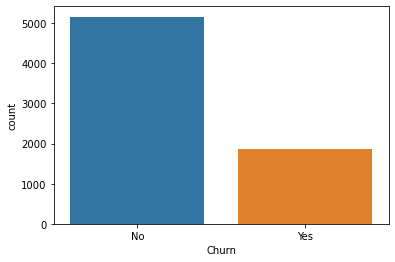

In [7]:
Bar_Pred = sns.countplot(x='Churn',data=df)
plt.show()

Overall lower frequency of churn in the dataset

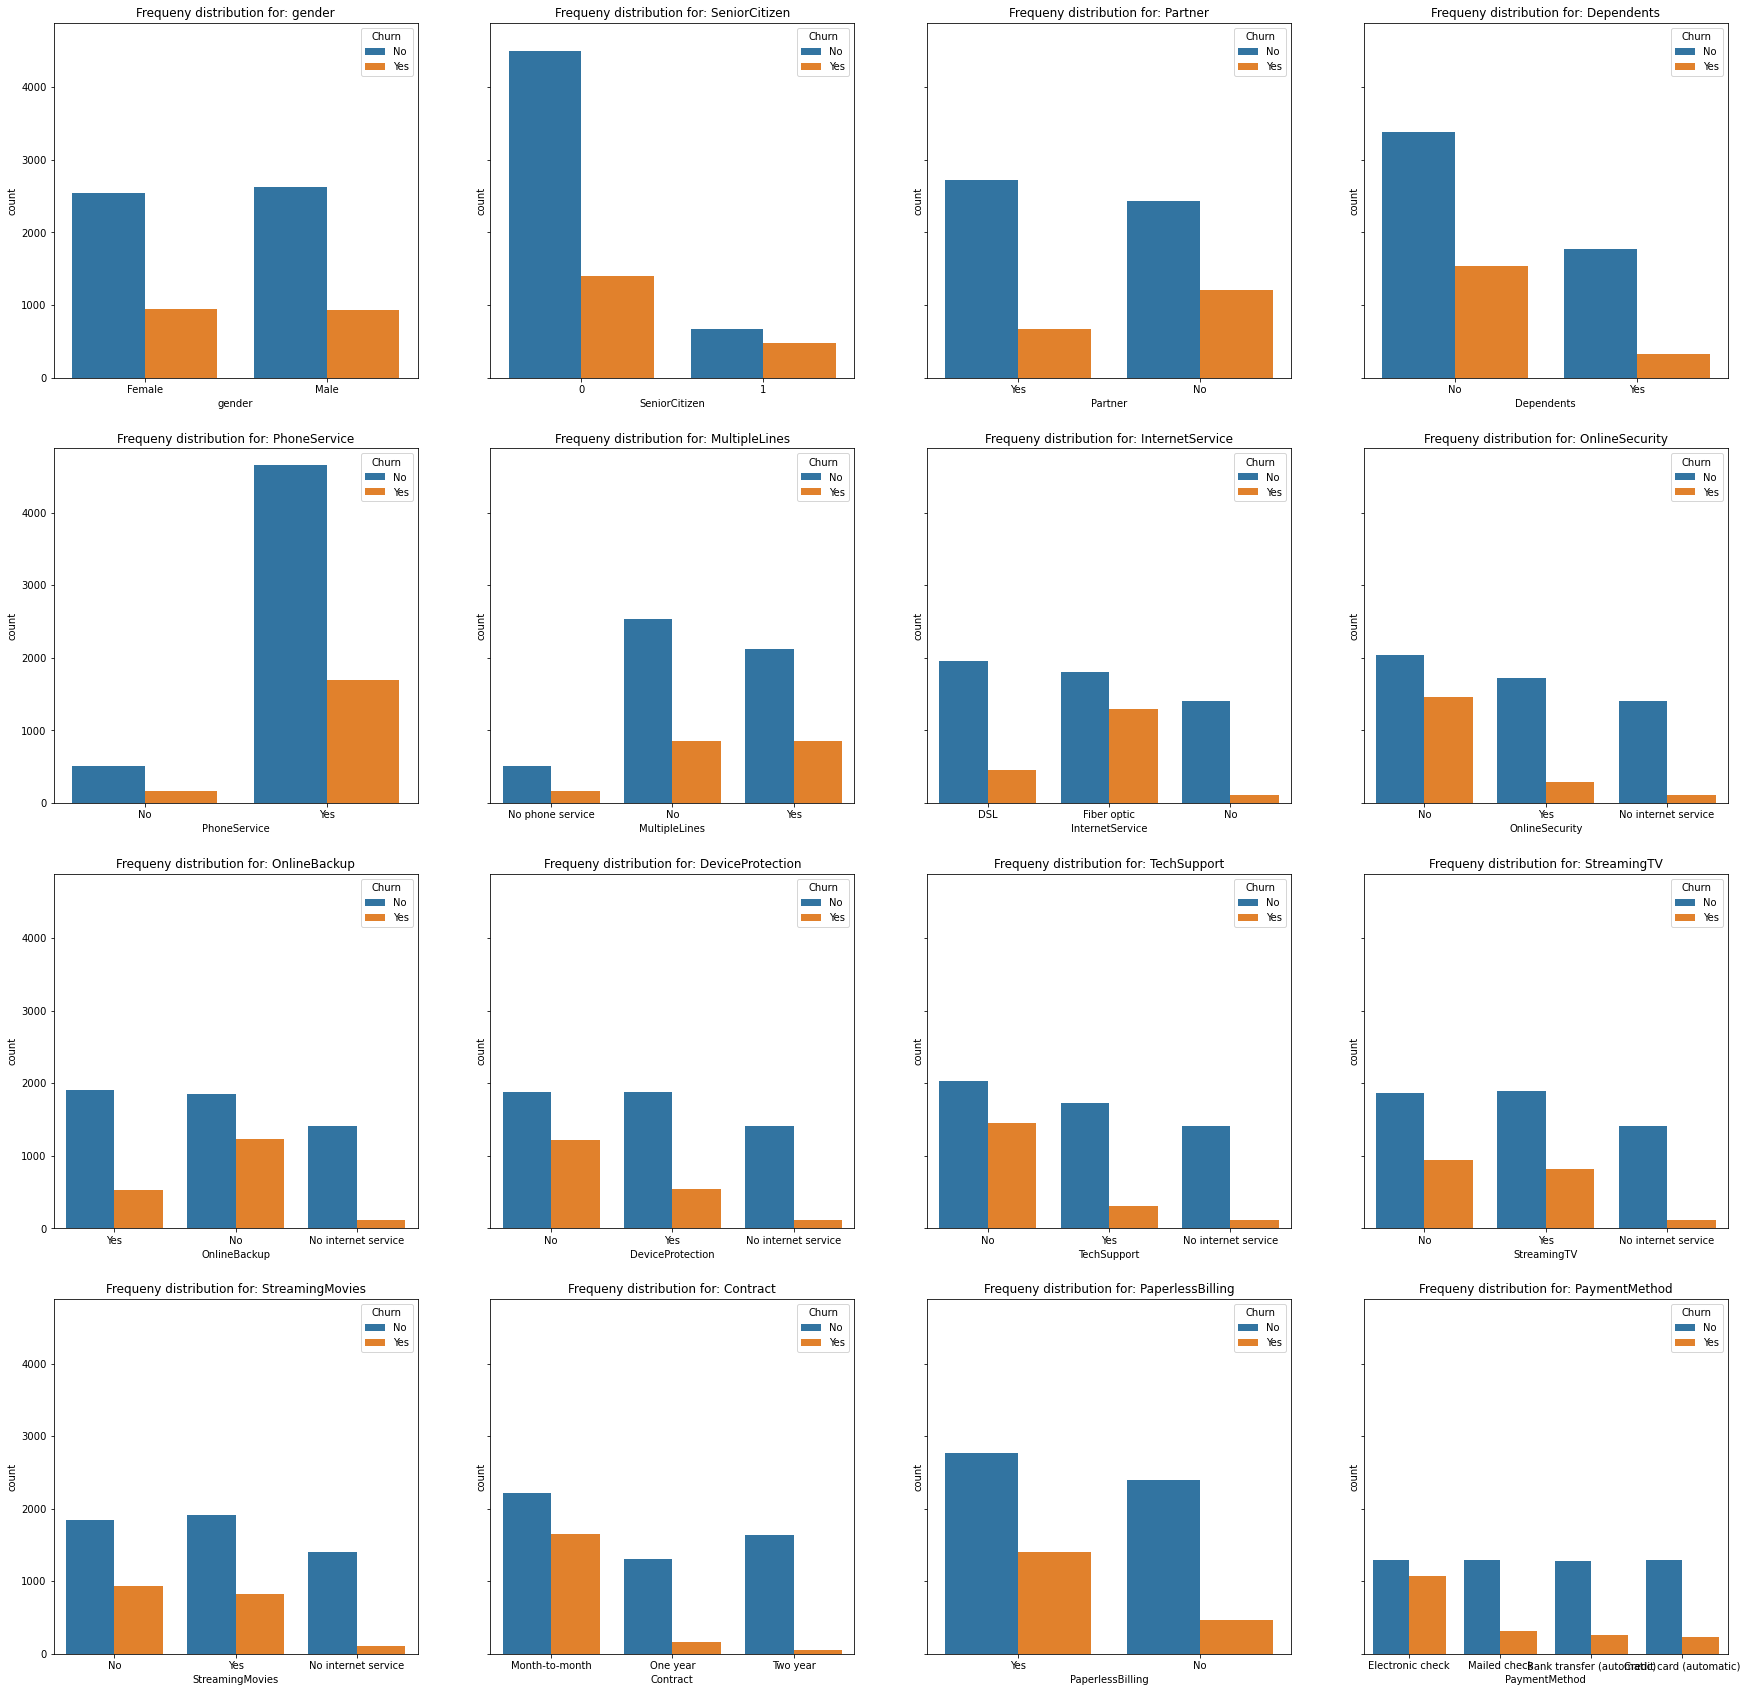

In [8]:
fig, axs = plt.subplots(4, 4, sharex=False, sharey=True, figsize=(30,30))

count_row = 0
count_columns = 0
for column in columns_5:    
    
    
    Bar_Plot = sns.countplot(x=column,hue='Churn',data=df,ax = axs[count_row][count_columns]).set_title("Frequeny distribution for: " + str(column))
        
   
    count_columns +=1
    
    if count_columns == 4:
        count_row+=1
        count_columns=0

### Although freuquency of churn is generally lower, let's look at some significant results
```
1. Non senior citizens are less likely to churn propprtionally to senior citizens   
2. Presence of a phone service and tech support play an important role in preventing customer churn
3. Contracts without paperless billing are less likely to churn than paperless billing  
4. Customers with DSL service are propotionally less likely to churn than with fiber optic

```



### Let's look at how these categorical features are correlated

In [9]:
df_corr = df[columns_5]

# Cramers V for categorical correlations
def cramers_v(x, y):
    x = np.array(x)
    y = np.array(y)
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

cramersv = pd.DataFrame(index=df_corr.columns,columns=df_corr.columns)
columns = df_corr.columns

for i in range(0,len(columns)):
    for j in range(0,len(columns)):
        #print(data[columns[i]].tolist())
        u = cramers_v(df_corr[columns[i]].tolist(),df_corr[columns[j]].tolist())
        cramersv.loc[columns[i],columns[j]] = u
        
cramersv.fillna(value=np.nan,inplace=True)


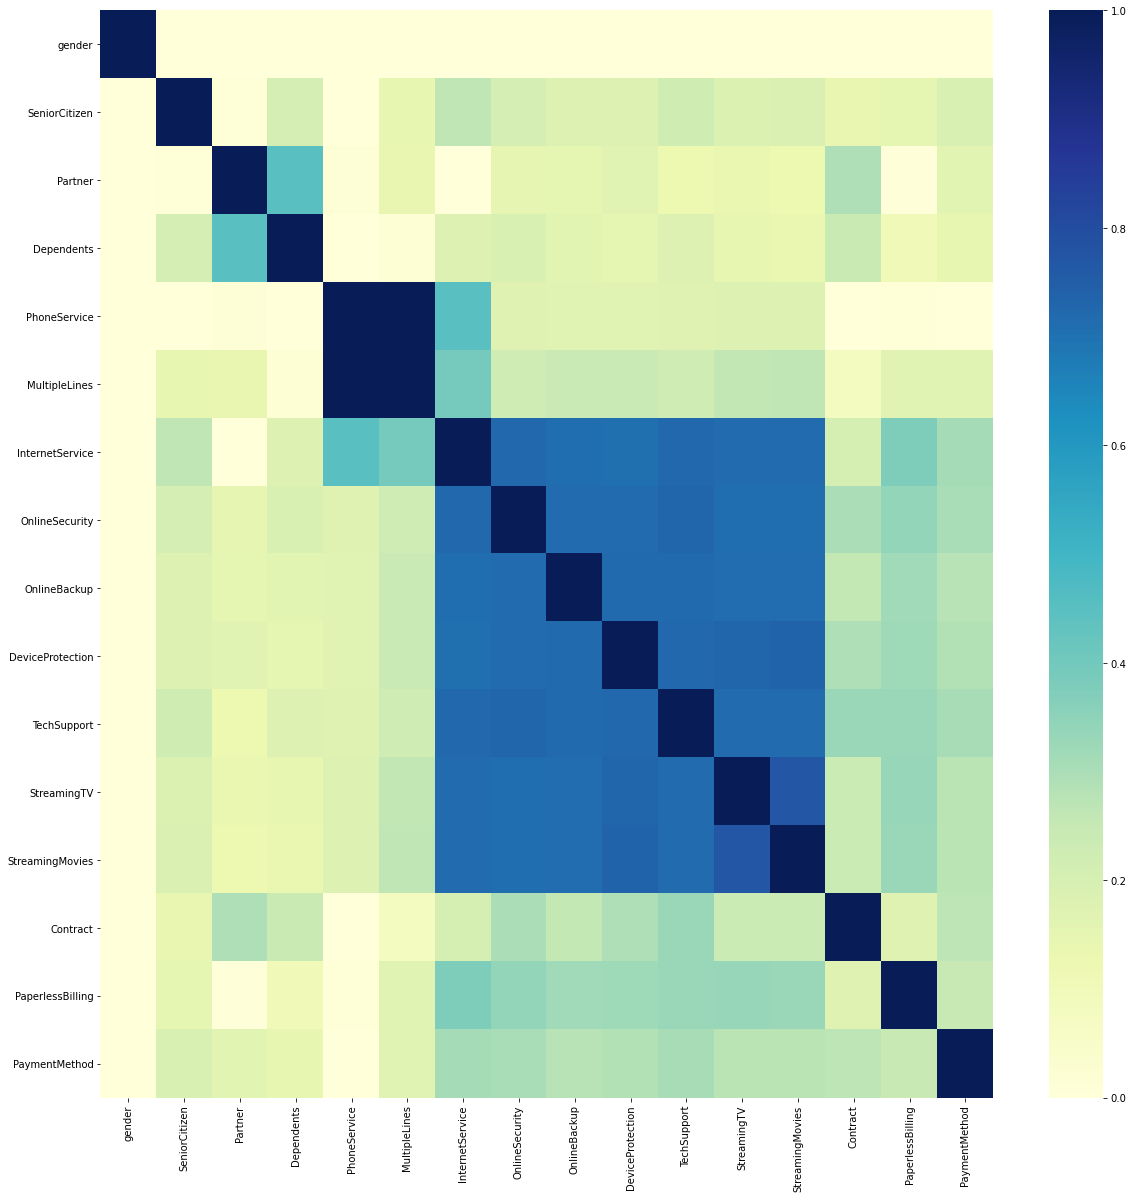

In [10]:
plt.figure(figsize=(20,20))
sns.heatmap(cramersv,cmap="YlGnBu")
plt.show()

- Apart from the expected correlation between partners and dependants, there is a strong correlation between the phone service and presence of multiple lines (or multiple phone numbers for the same customer). My guess is that a good service prompts customers to order multiple lines
- Also users of internet security avail other internet based features
- Let's look at phone service a bit more closely

In [11]:

df_PS = df[["PhoneService","MultipleLines"]]
Total_yes_multiple_lines = len(df_PS[(df_PS["MultipleLines"]=="Yes")])



# Check for relation between good phone service and multiple lines
df_CS_corr = df_PS[(df_PS["PhoneService"]=="Yes") & (df_PS["MultipleLines"]=="Yes")]

print("Percentage of users with multiple lines having good phone service " + str(len(df_CS_corr)*100/Total_yes_multiple_lines) + " %") 


Percentage of users with multiple lines having good phone service 100.0 %


- This confirms the fact that good service leads to multiple subscriptions

### Lets look at the relation between tenure to churn for customers who have terminated their service

In [12]:
df_churn = df[df["Churn"]=="Yes"]

<AxesSubplot:xlabel='tenure', ylabel='Count'>

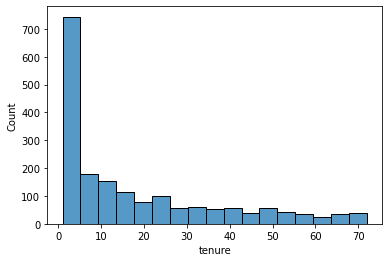

In [13]:
sns.histplot(df_churn["tenure"])


- Highest frequency of churn in the first 10 months. Customers make up their mind within the first 10 months to terminate or continue their service

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Count'>

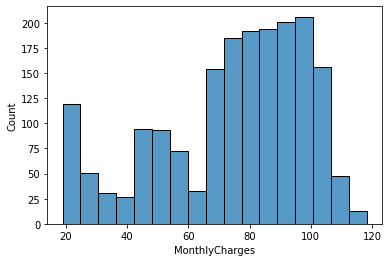

In [14]:
sns.histplot(df_churn["MonthlyCharges"])

- Monthly charges between 60 and 110 have a high frequency count but can not infer any significant meaning

### Let's look at the prediction by evaluating three models
```
1. Light gbm
2. Random forest
3. Logistic regression
```

In [15]:
df['TotalCharges'] = df['TotalCharges'].apply(float)

# Rather than label encoding, we can convert the categorical values to dummy variables. 
# This can help evaluate individual fetures directly
y = df["Churn"]
df = df.drop(columns=["Churn","customerID"])

df = pd.get_dummies(df)
print(df.head(10))

X = df
y = y.values
y = y.reshape((len(y), 1))




   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  gender_Female  \
0              0       1           29.85         29.85              1   
1              0      34           56.95       1889.50              0   
2              0       2           53.85        108.15              0   
3              0      45           42.30       1840.75              0   
4              0       2           70.70        151.65              1   
5              0       8           99.65        820.50              1   
6              0      22           89.10       1949.40              0   
7              0      10           29.75        301.90              1   
8              0      28          104.80       3046.05              1   
9              0      62           56.15       3487.95              0   

   gender_Male  Partner_No  Partner_Yes  Dependents_No  Dependents_Yes  ...  \
0            0           0            1              1               0  ...   
1            1           1            

In [16]:
# split into train and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

- Random Forest

In [17]:
clf=RandomForestClassifier()

param_test={
        'n_estimators': range(200,500,100), 
        'min_samples_leaf': range(10,20,10), 
        'min_samples_split': range(10,20,10),  
        'max_depth': range(40,60,10)       
    }
            
model = RandomizedSearchCV(
  estimator=clf, param_distributions=param_test, 
   scoring='accuracy',
   random_state=314,
   verbose=True, n_iter=10)
result = model.fit(X_train, y_train)
            
print("Best Score " + str(result.best_score_)+" with paramter "+ str(result.best_params_))

model1 = RandomForestClassifier(n_estimators=result.best_params_['n_estimators'],
                              min_samples_split=result.best_params_['min_samples_split'],
                              min_samples_leaf=result.best_params_['min_samples_leaf'], 
                              max_depth=result.best_params_['max_depth'])

model1.fit(X_train, y_train)

pred = model1.predict(X_test)
print('Accuracy:',accuracy_score(pred,y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Score 0.8040888888888891 with paramter {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 50}
Accuracy: 0.7924662402274343


- Light GBM

In [18]:
clf= LGBMClassifier()

param_test ={  'n_estimators': [400, 700, 1000],
  'colsample_bytree': [0.7, 0.8],
  'max_depth': [15,20,25],
   'num_leaves': [50, 100, 200],
  'reg_alpha': [1.1, 1.2, 1.3],
 'reg_lambda': [1.1, 1.2, 1.3],
 'min_split_gain': [0.3, 0.4],
 'subsample': [0.7, 0.8, 0.9],
  'subsample_freq': [20]}

model = RandomizedSearchCV(
  estimator=clf, param_distributions=param_test, 
   scoring='accuracy',
   random_state=314,
   verbose=True, n_iter=10)
result = model.fit(X_train, y_train)
            
print("Best Score " + str(result.best_score_)+" with paramter "+ str(result.best_params_))

model2 = LGBMClassifier(subsample_freq= result.best_params_['subsample_freq'],subsample= result.best_params_['subsample'], 
                       reg_lambda= result.best_params_['reg_lambda'], reg_alpha = result.best_params_['reg_alpha'], 
                       num_leaves = result.best_params_['num_leaves'], n_estimators = result.best_params_['n_estimators'], 
                       min_split_gain = result.best_params_['min_split_gain'], max_depth = result.best_params_['max_depth'], 
                       colsample_bytre = result.best_params_['colsample_bytree'])

model2.fit(X_train, y_train)

pred = model2.predict(X_test)
print('Accuracy:',accuracy_score(pred,y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Score 0.8028444444444445 with paramter {'subsample_freq': 20, 'subsample': 0.7, 'reg_lambda': 1.1, 'reg_alpha': 1.1, 'num_leaves': 100, 'n_estimators': 400, 'min_split_gain': 0.3, 'max_depth': 20, 'colsample_bytree': 0.8}
Accuracy: 0.7896233120113717


- Logistic regression

In [19]:
model3 = LogisticRegression()
model3.fit(X_train, y_train)

pred = model3.predict(X_test)
print('Accuracy:',accuracy_score(pred,y_test))

Accuracy: 0.7853589196872779


- With similar performances, lets find out the important features contributing to the model performance (Random forest classifier)

<AxesSubplot:>

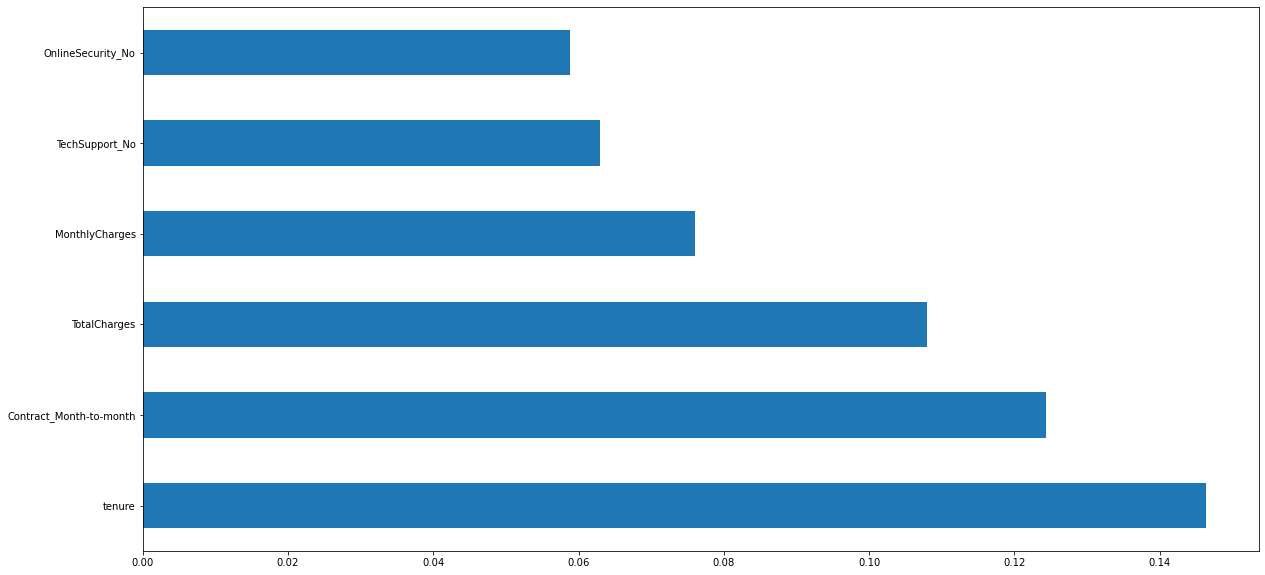

In [20]:
plt.figure(figsize=(20,10))
feat_importances = pd.Series(model1.feature_importances_, index=X_train.columns)
feat_importances.nlargest(6).plot(kind='barh')

- Tenure, Contract_Month to Month, Montly Charges, Total charges and Tech support no seem to contribute the most to the churn (Top 5)
- From the distribution plots, it can be inferred that customers make up their mind to terminate within the first 10 months
- Also, customers with a two year contract are less likely to churn than a month to month contract
- Additionaly customer support are good measures to prevent the company from losing customers. Also as inferred above, customer support enables multiple subscribers

### As always would love to receive feedback on any improvement or mistake